In [ ]:
import torch_geometric.transforms as T
import os.path as osp
from sklearn.manifold import TSNE
import torch
import umap

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from embedding_functions import *
from experiment_setup import *
from functions_for_bootstrap import *
import numba as nb
from scipy.stats import wasserstein_distance
from tqdm import tqdm
import random
from scipy.integrate import simps
from matplotlib import cm
from matplotlib.patches import Ellipse
import seaborn as sns
from scipy.spatial.distance import cdist
from numpy.linalg import LinAlgError
import re

from sklearn.preprocessing import StandardScaler

Read in data

In [2]:
window = 60 * 60

day_1_start = (8 * 60 + 30) * 60
day_1_end = (17 * 60 + 30) * 60
day_2_start = ((24 + 8) * 60 + 30) * 60
day_2_end = ((24 + 17) * 60 + 30) * 60

T1 = int((day_1_end - day_1_start) // window)
T2 = int((day_2_end - day_2_start) // window)
T = T1 + T2

print(f"Number of time windows: {T}")

# %%
fname = "ia-primary-school-proximity-attr.edges"
file = open(fname)

label_dict = {
    "1A": 0,
    "1B": 1,
    "2A": 2,
    "2B": 3,
    "3A": 4,
    "3B": 5,
    "4A": 6,
    "4B": 7,
    "5A": 8,
    "5B": 9,
    "Teachers": 10,
}
num_classes = 10

nodes = []
node_labels = []
edge_tuples = []

for line in file:
    node_i, node_j, time, id_i, id_j = line.strip("\n").split(",")

    if day_1_start <= int(time) < day_1_end:
        t = (int(time) - day_1_start) // window
    elif day_2_start <= int(time) < day_2_end:
        t = T1 + (int(time) - day_2_start) // window
    else:
        continue

    if node_i not in nodes:
        nodes.append(node_i)
        node_labels.append(label_dict[id_i])

    if node_j not in nodes:
        nodes.append(node_j)
        node_labels.append(label_dict[id_j])

    edge_tuples.append([t, node_i, node_j])

edge_tuples = np.unique(edge_tuples, axis=0)
nodes = np.array(nodes)

n = len(nodes)
print(f"Number of nodes: {n}")

node_dict = dict(zip(nodes[np.argsort(node_labels)], range(n)))
node_labels = np.sort(node_labels)

# %% [markdown]
# Create a list of adjacency matrices.

# %%
As = np.zeros((T, n, n))

for m in range(len(edge_tuples)):
    t, i, j = edge_tuples[m]
    As[int(t), node_dict[i], node_dict[j]] = 1
    As[int(t), node_dict[j], node_dict[i]] = 1

Number of time windows: 18
Number of nodes: 242


In [3]:
# Format the data to work with existing code
labels = node_labels

# just look at first (whatever is specified) timepoint
dense_adj = As[0]

Define functions for notebook

In [6]:
def compute_area_above_below_curve(x, y):
    area_above = 0.0
    area_below = 0.0
    
    for i in range(1, len(x)):
        x0, x1 = x[i - 1], x[i]
        y0, y1 = y[i - 1], y[i]
        line0, line1 = x0, x1  # Since line y = x
        
        if y1 == y0:  # Vertical segment
            if y0 > x0:
                area_above += (y0 - x0) * (x1 - x0)
            else:
                area_below += (x0 - y0) * (x1 - x0)
            continue
        
        # Find intersection with y = x
        if (y0 >= x0 and y1 >= x1) or (y0 <= x0 and y1 <= x1):
            if y0 >= x0 and y1 >= x1:
                area_above += 0.5 * (y0 + y1 - x0 - x1) * (x1 - x0)
            else:
                area_below += 0.5 * (x0 + x1 - y0 - y1) * (x1 - x0)
        else:
            x_intersect = x0 + (x0 - y0) * (x1 - x0) / (y1 - y0)
            if y0 < x0:
                area_below += 0.5 * (x0 - y0) * (x_intersect - x0)
                area_above += 0.5 * (y1 - x1) * (x1 - x_intersect)
            else:
                area_above += 0.5 * (y0 - x0) * (x_intersect - x0)
                area_below += 0.5 * (x1 - y1) * (x1 - x_intersect)
    
    return area_above, area_below


# def plot_ellipse(ax, mean, cov, color):
#     eigenvalues, eigenvectors = np.linalg.eigh(cov)
#     order = eigenvalues.argsort()[::-1]
#     eigenvalues = eigenvalues[order]
#     eigenvectors = eigenvectors[:, order]
#     angle = np.degrees(np.arctan2(*eigenvectors[:, 0][::-1]))
#     width, height = 2 * np.sqrt(eigenvalues[:2])
#     ellipse = Ellipse(mean, width, height, angle, edgecolor=color, facecolor='none', lw=2, label=f'Covariance Ellipse ({color})')
#     ax.add_patch(ellipse)


def plot_ellipse(ax, mean, cov, color, lw=2):
    eigenvalues, eigenvectors = np.linalg.eigh(cov)
    order = eigenvalues.argsort()[::-1]
    eigenvalues = eigenvalues[order]
    eigenvectors = eigenvectors[:, order]
    angle = np.degrees(np.arctan2(*eigenvectors[:, 0][::-1]))
    width, height = 2 * np.sqrt(eigenvalues[:2])
    ellipse = Ellipse(xy=mean, width=width, height=height, angle=angle, edgecolor=color, facecolor='none', lw=lw, label=f'Covariance Ellipse ({color})')
    ax.add_patch(ellipse)



# TO AVOID SINGULAR MATRIX ERROR
def points_within_ellipse(points, mean, cov, regularization=1e-32):
    try:
        # Attempt to calculate the inverse of the covariance matrix
        inv_cov = np.linalg.inv(cov)
    except LinAlgError:
        # If the matrix is singular, regularize and retry
        cov += np.eye(cov.shape[0]) * regularization
        inv_cov = np.linalg.inv(cov)
    
    # Calculate the Mahalanobis distance from the mean
    diff = points - mean
    mahalanobis_distances = np.sum(diff @ inv_cov * diff, axis=1)
    
    # Points within the ellipse have a Mahalanobis distance <= 1
    return mahalanobis_distances <= 1


In [79]:
k = 4
d = 2

In [80]:
B_max = 200
B_min = 20
B_values = range(B_min, B_max, 1)  # Example B values
B = B_max - B_min

A_boots_list = []

# Create max(B_values) bootstraps
for b in range(len(B_values)):
    _, A_boots = create_single_kNN_bootstrap(dense_adj, d=d, Q=1000, n_neighbors=k)
    A_boots_list.append(A_boots)

A_list = [dense_adj] + A_boots_list
yhat = UASE(A_list, d=d, sparse_matrix=False)

yadf = pd.DataFrame(yhat)
# rename the columns - this is called a list comprehension
yadf.columns = ["Dimension_{}".format(i+1) for i in range(yadf.shape[1])] 

# Standardize the data in the Dimension_1 and Dimension_2 columns
# standardize the data for the obs and the B bootstraps for each B value
# scaler = StandardScaler()
# yadf[["Dimension_1", "Dimension_2"]] = scaler.fit_transform(yadf[["Dimension_1", "Dimension_2"]])

# repeat range(len(node_labels)) B+1 times to give each node a unique number
yadf['NodeNumber'] = list(range(len(node_labels)))*(len(B_values)+1)

# repeats tau list the len of A_true_boots_list times
yadf["tau"] = np.tile(node_labels, B +1)

# add column for the matrix it is
yadf["Matrix"] = np.repeat(range(B + 1), len(labels))

100%|██████████| 180/180 [00:00<00:00, 984.08it/s] 


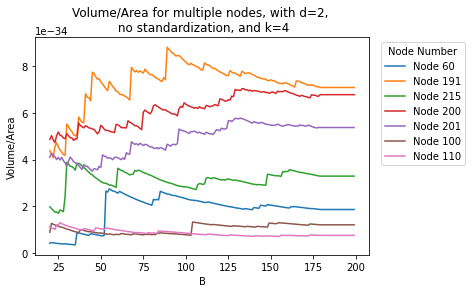

In [84]:
# Define a list of node indices to plot for
i_values = [60, 191, 215, 200, 201, 100, 110]  # Example node indices
Sigma_list_dict = {}

# Iterate over each node in i_values
for i in i_values:
    Sigma_list_i = []

    # Iterate over B values
    for b in tqdm(B_values):
        yadf_b = yadf[yadf['Matrix'] <= b+1]

        # Filter data for node number and select the relevant dimensions
        node_number = i
        data_d_dim = yadf_b[yadf_b["NodeNumber"] == node_number].iloc[:, 0:d].to_numpy()

        # Calculate the covariance considering all d dimensions
        cov_d_dim = np.cov(data_d_dim, rowvar=False)

        # Compute the determinant of the covariance matrix
        det_cov = np.linalg.det(cov_d_dim)

        # Ensure determinant is non-negative
        if det_cov >= 0:
            volume_or_area = np.sqrt(det_cov)
        else:
            volume_or_area = np.nan  # Handle negative determinant
            print(f"Warning: Negative determinant encountered for node {i} and B={b} bootstraps, setting volume/area to NaN.")

        Sigma_list_i.append(volume_or_area)

    # Store Sigma_list_i for this node i
    Sigma_list_dict[i] = Sigma_list_i

    # Plot for each node
    plt.plot(B_values, Sigma_list_i, label=f'Node {i}')

# Final plot settings
plt.xlabel("B")
plt.ylabel("Volume/Area")
plt.title(f"Volume/Area for multiple nodes, with d={d}, \n no standardization, and k={k}")
plt.legend(title="Node Number", loc='upper right', bbox_to_anchor=(1.3, 1))

plt.savefig(f"Volume_Area_Multiple_Nodes_d{d}_noStandardisation.png", dpi=300, bbox_inches='tight', facecolor='w')

plt.show()


multiple d choices plot in one plot

In [85]:
k = 4

100%|██████████| 180/180 [00:00<00:00, 1128.64it/s]


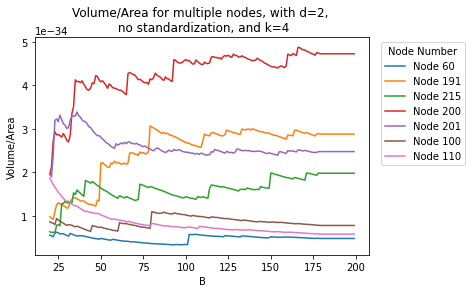

100%|██████████| 180/180 [00:00<00:00, 953.90it/s] 


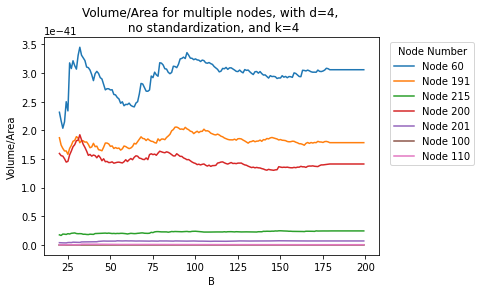

In [98]:
B_max = 200
B_min = 20
B_values = range(B_min, B_max, 1)  # Example B values
B = B_max - B_min

for d in [2,4]:

    A_boots_list = []

    # Create max(B_values) bootstraps
    for b in range(len(B_values)):
        _, A_boots = create_single_kNN_bootstrap(dense_adj, d=d, Q=1000, n_neighbors=k)
        A_boots_list.append(A_boots)

    A_list = [dense_adj] + A_boots_list
    yhat = UASE(A_list, d=d, sparse_matrix=False)

    yadf = pd.DataFrame(yhat)
    # rename the columns - this is called a list comprehension
    yadf.columns = ["Dimension_{}".format(i+1) for i in range(yadf.shape[1])] 

    # Standardize the data in the Dimension_1 and Dimension_2 columns
    # standardize the data for the obs and the B bootstraps for each B value
    # scaler = StandardScaler()
    # yadf[["Dimension_1", "Dimension_2"]] = scaler.fit_transform(yadf[["Dimension_1", "Dimension_2"]])

    # repeat range(len(node_labels)) B+1 times to give each node a unique number
    yadf['NodeNumber'] = list(range(len(node_labels)))*(len(B_values)+1)

    # repeats tau list the len of A_true_boots_list times
    yadf["tau"] = np.tile(node_labels, B +1)

    # add column for the matrix it is
    yadf["Matrix"] = np.repeat(range(B + 1), len(labels))

    # Define a list of node indices to plot for
    i_values = [60, 191, 215, 200, 201, 100, 110]  # Example node indices
    Sigma_list_dict = {}

    # Iterate over each node in i_values
    for i in i_values:
        Sigma_list_i = []

        # Iterate over B values
        for b in tqdm(B_values):
            yadf_b = yadf[yadf['Matrix'] <= b+1]

            # Filter data for node number and select the relevant dimensions
            node_number = i
            data_d_dim = yadf_b[yadf_b["NodeNumber"] == node_number].iloc[:, 0:d].to_numpy()

            # Calculate the covariance considering all d dimensions
            cov_d_dim = np.cov(data_d_dim, rowvar=False)

            # Compute the determinant of the covariance matrix
            det_cov = np.linalg.det(cov_d_dim)

            # Ensure determinant is non-negative
            if det_cov >= 0:
                volume_or_area = np.sqrt(det_cov)
            else:
                volume_or_area = np.nan  # Handle negative determinant
                print(f"Warning: Negative determinant encountered for node {i} and B={b} bootstraps, setting volume/area to NaN.")

            Sigma_list_i.append(volume_or_area)

        # Store Sigma_list_i for this node i
        Sigma_list_dict[i] = Sigma_list_i

        # Plot for each node
        plt.plot(B_values, Sigma_list_i, label=f'Node {i}')

    # Final plot settings
    plt.xlabel("B")
    plt.ylabel("Volume/Area")
    plt.title(f"Volume/Area for multiple nodes, with d={d}, \n no standardization, and k={k}")
    plt.legend(title="Node Number", loc='upper right', bbox_to_anchor=(1.3, 1))

    # plt.savefig(f"Volume_Area_Multiple_Nodes_d{d}_noStandardisation.png", dpi=300, bbox_inches='tight', facecolor='w')

    plt.show()


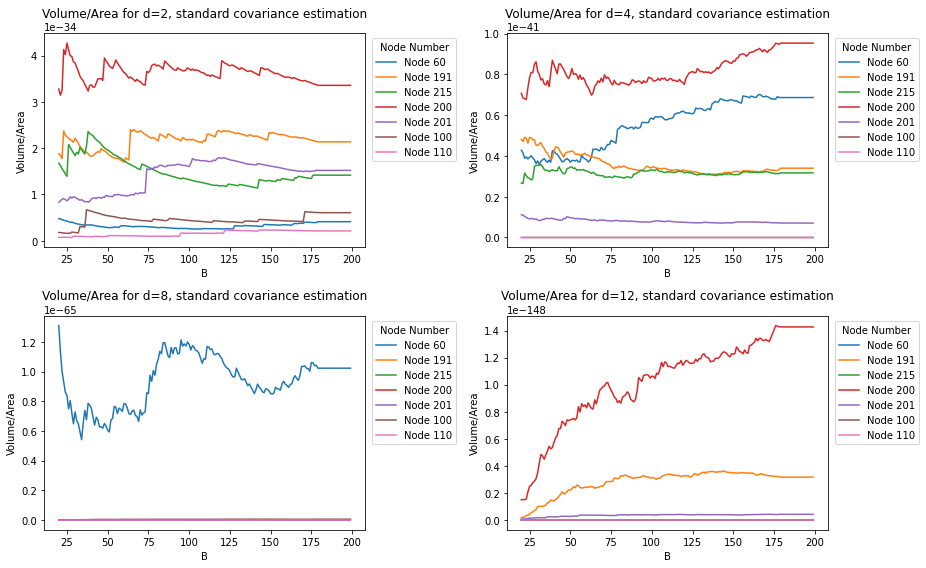

In [95]:
B_max = 200
B_min = 20
B_values = range(B_min, B_max, 1)  # Example B values
B = B_max - B_min

# Example node indices
i_values = [60, 191, 215, 200, 201, 100, 110]  

# Create a 2x2 grid for the plots
fig, axes = plt.subplots(2, 2, figsize=(13,8))  # 2x2 grid of plots
axes = axes.flatten()  # Flatten the axes array for easier indexing

# Iterate over different dimensions and corresponding subplot axes
for idx, d in enumerate([2, 4, 8, 12]):

    A_boots_list = []

    # Create max(B_values) bootstraps
    for b in range(len(B_values)):
        _, A_boots = create_single_kNN_bootstrap(dense_adj, d=d, Q=1000, n_neighbors=k)
        A_boots_list.append(A_boots)

    A_list = [dense_adj] + A_boots_list
    yhat = UASE(A_list, d=d, sparse_matrix=False)

    yadf = pd.DataFrame(yhat)
    yadf.columns = ["Dimension_{}".format(i+1) for i in range(yadf.shape[1])] 

    # Add node and matrix metadata
    yadf['NodeNumber'] = list(range(len(node_labels)))*(len(B_values)+1)
    yadf["tau"] = np.tile(node_labels, B +1)
    yadf["Matrix"] = np.repeat(range(B + 1), len(node_labels))

    # Select the current subplot axis
    ax = axes[idx]

    # Iterate over each node in i_values
    for i in i_values:
        Sigma_list_i = []

        # Iterate over B values
        for b in B_values: #tqdm(B_values):
            yadf_b = yadf[yadf['Matrix'] <= b+1]

            # Filter data for node number and select the relevant dimensions
            node_number = i
            data_d_dim = yadf_b[yadf_b["NodeNumber"] == node_number].iloc[:, 0:d].to_numpy()

            # Calculate the covariance considering all d dimensions
            cov_d_dim = np.cov(data_d_dim, rowvar=False)

            # Compute the determinant of the covariance matrix
            det_cov = np.linalg.det(cov_d_dim)

            # Ensure determinant is non-negative
            if det_cov >= 0:
                volume_or_area = np.sqrt(det_cov)
            else:
                volume_or_area = np.nan
                print(f"Warning: Negative determinant encountered for node {i} and B={b} bootstraps, setting volume/area to NaN.")

            Sigma_list_i.append(volume_or_area)

        # Plot for each node on the current axis
        ax.plot(B_values, Sigma_list_i, label=f'Node {i}')

    ax.set_xlabel("B")
    ax.set_ylabel("Volume/Area")
    ax.set_title(f"Volume/Area for d={d}, standard covariance estimation")
    ax.legend(title="Node Number", loc='upper right',bbox_to_anchor=(1.3, 1))

plt.tight_layout()

plt.savefig(f"Volume_Area_Multiple_Nodes_multiple_d.png", dpi=300, bbox_inches='tight', facecolor='w')

plt.show()

### Banding the Sample Covariance Matrix - for Regularised estimation of large covariance matrices

In [119]:
import numpy as np
from sklearn.covariance import EmpiricalCovariance

def band_covariance_matrix(cov_matrix, band_size):
    """
    Function to apply banding to a covariance matrix.
    
    Parameters:
    cov_matrix (np.ndarray): Input covariance matrix (n x n).
    band_size (int): The size of the band around the diagonal to keep.
    
    Returns:
    np.ndarray: The banded covariance matrix.
    """
    # Create a mask for the banded matrix
    banded_cov_matrix = np.zeros_like(cov_matrix)
    
    # Only retain elements within the band_size around the diagonal
    for i in range(cov_matrix.shape[0]):
        for j in range(max(0, i-band_size), min(cov_matrix.shape[1], i+band_size+1)):
            banded_cov_matrix[i, j] = cov_matrix[i, j]
    
    return banded_cov_matrix


# Example usage
np.random.seed(42)
data = np.random.randn(100, 5)  # 100 samples, 5 features

# Estimate the empirical covariance matrix
cov_estimator = EmpiricalCovariance()
cov_estimator.fit(data)
cov_matrix = cov_estimator.covariance_

# Banding the covariance matrix with band size = 1
band_size = 1
banded_cov_matrix = band_covariance_matrix(cov_matrix, band_size)

# Print results
print("Original Covariance Matrix:")
print(cov_matrix)

cov_d_dim = np.cov(data, rowvar=False)
print("\nCovariance Matrix:")
print(cov_d_dim)

print("\nBanded Covariance Matrix (band_size=1):")
print(banded_cov_matrix)


Original Covariance Matrix:
[[ 0.80252788 -0.14336087  0.03934938 -0.08709697 -0.12066234]
 [-0.14336087  0.958788    0.11768497  0.0357257   0.05973892]
 [ 0.03934938  0.11768497  0.95846335  0.00796798  0.04474733]
 [-0.08709697  0.0357257   0.00796798  0.91153946  0.01870954]
 [-0.12066234  0.05973892  0.04474733  0.01870954  1.13940375]]

Covariance Matrix:
[[ 0.81063422 -0.14480896  0.03974684 -0.08797673 -0.12188116]
 [-0.14480896  0.96847272  0.11887371  0.03608656  0.06034235]
 [ 0.03974684  0.11887371  0.9681448   0.00804846  0.04519932]
 [-0.08797673  0.03608656  0.00804846  0.92074693  0.01889852]
 [-0.12188116  0.06034235  0.04519932  0.01889852  1.15091288]]

Banded Covariance Matrix (band_size=1):
[[ 0.80252788 -0.14336087  0.          0.          0.        ]
 [-0.14336087  0.958788    0.11768497  0.          0.        ]
 [ 0.          0.11768497  0.95846335  0.00796798  0.        ]
 [ 0.          0.          0.00796798  0.91153946  0.01870954]
 [ 0.          0.          

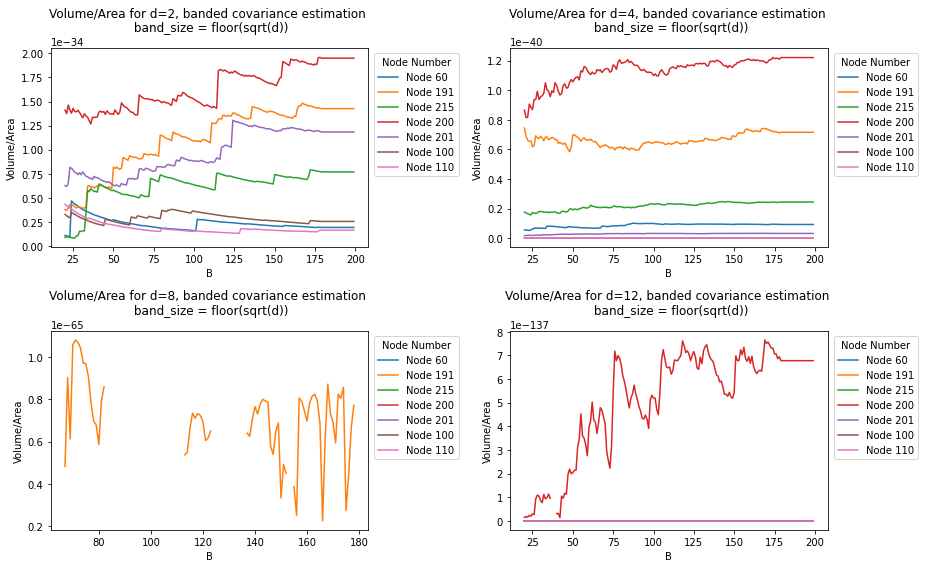

In [120]:
B_max = 200
B_min = 20
B_values = range(B_min, B_max, 1)  # Example B values
B = B_max - B_min

# for banded inverse covariance matrix 
band_size = np.floor(np.sqrt(d)).astype(int)

# Example node indices
i_values = [60, 191, 215, 200, 201, 100, 110]  

# Create a 2x2 grid for the plots
fig, axes = plt.subplots(2, 2, figsize=(13,8))  # 2x2 grid of plots
axes = axes.flatten()  # Flatten the axes array for easier indexing

# Iterate over different dimensions and corresponding subplot axes
for idx, d in enumerate([2, 4, 8, 12]):

    A_boots_list = []

    # Create max(B_values) bootstraps
    for b in range(len(B_values)):
        _, A_boots = create_single_kNN_bootstrap(dense_adj, d=d, Q=1000, n_neighbors=k)
        A_boots_list.append(A_boots)

    A_list = [dense_adj] + A_boots_list
    yhat = UASE(A_list, d=d, sparse_matrix=False)

    yadf = pd.DataFrame(yhat)
    yadf.columns = ["Dimension_{}".format(i+1) for i in range(yadf.shape[1])] 

    # Add node and matrix metadata
    yadf['NodeNumber'] = list(range(len(node_labels)))*(len(B_values)+1)
    yadf["tau"] = np.tile(node_labels, B +1)
    yadf["Matrix"] = np.repeat(range(B + 1), len(node_labels))

    # Select the current subplot axis
    ax = axes[idx]

    # Iterate over each node in i_values
    for i in i_values:
        Sigma_list_i = []

        # Iterate over B values
        for b in B_values: #tqdm(B_values):
            yadf_b = yadf[yadf['Matrix'] <= b+1]

            # Filter data for node number and select the relevant dimensions
            node_number = i
            data_d_dim = yadf_b[yadf_b["NodeNumber"] == node_number].iloc[:, 0:d].to_numpy()

            # CALCULATE THE BANDED COVARIANCE MATRIX
            cov_d_dim_empirical = np.cov(data_d_dim, rowvar=False)
            cov_d_dim = band_covariance_matrix(cov_d_dim_empirical, band_size)

            # Compute the determinant of the covariance matrix
            det_cov = np.linalg.det(cov_d_dim)

            # Ensure determinant is non-negative
            if det_cov >= 0:
                volume_or_area = np.sqrt(det_cov)
            else:
                volume_or_area = np.nan
                print(f"Warning: Negative determinant encountered for node {i} and B={b} bootstraps, setting volume/area to NaN.")

            Sigma_list_i.append(volume_or_area)

        # Plot for each node on the current axis
        ax.plot(B_values, Sigma_list_i, label=f'Node {i}')

    ax.set_xlabel("B")
    ax.set_ylabel("Volume/Area")
    ax.set_title(f"Volume/Area for d={d}, banded covariance estimation \n band_size = floor(sqrt(d))")
    ax.legend(title="Node Number", loc='upper right',bbox_to_anchor=(1.3, 1))

plt.tight_layout()

plt.savefig(f"Volume_Area_Multiple_Nodes_multiple_d_bandedCov.png", dpi=300, bbox_inches='tight', facecolor='w')

plt.show()

### Band the inverse, then invert to get Sigma back

In [121]:
# from chatGPT

def band_inverse_covariance(cov_matrix, band_size):
    """
    Function to band the inverse of a covariance matrix.
    
    Parameters:
    cov_matrix (np.ndarray): Input covariance matrix (n x n).
    band_size (int): The size of the band around the diagonal to keep.
    
    Returns:
    np.ndarray: The banded inverse covariance matrix.
    """
    # Compute the inverse of the covariance matrix (precision matrix)
    inv_cov_matrix = np.linalg.inv(cov_matrix)
    
    # Create a mask for the banded matrix
    banded_inv_cov_matrix = np.zeros_like(inv_cov_matrix)
    
    # Only retain elements within the band_size around the diagonal
    for i in range(inv_cov_matrix.shape[0]):
        for j in range(max(0, i-band_size), min(inv_cov_matrix.shape[1], i+band_size+1)):
            banded_inv_cov_matrix[i, j] = inv_cov_matrix[i, j]
    
    return banded_inv_cov_matrix

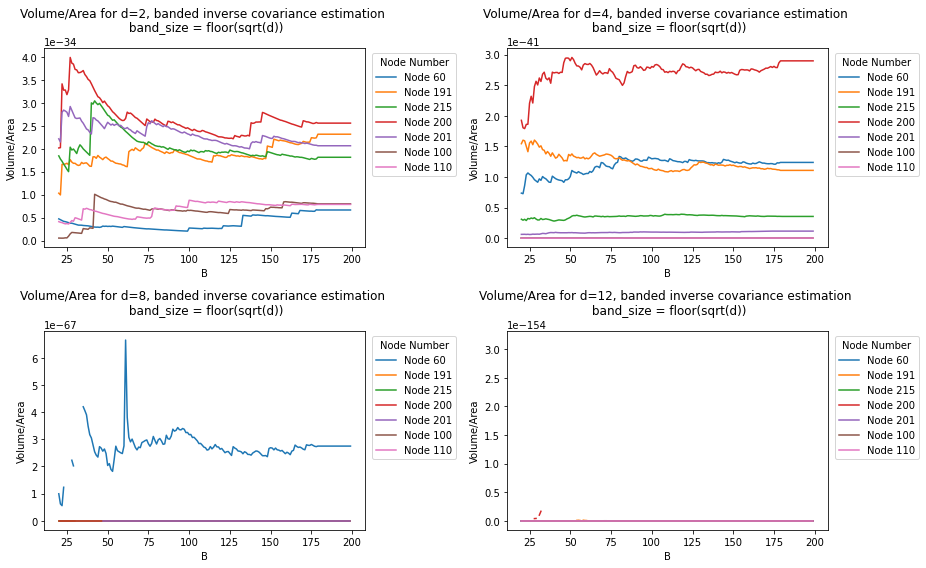

In [118]:
B_max = 200
B_min = 20
B_values = range(B_min, B_max, 1)  # Example B values
B = B_max - B_min

# for banded inverse covariance matrix 
band_size = np.floor(np.sqrt(d)).astype(int)

# Example node indices
i_values = [60, 191, 215, 200, 201, 100, 110]  

# Create a 2x2 grid for the plots
fig, axes = plt.subplots(2, 2, figsize=(13,8))  # 2x2 grid of plots
axes = axes.flatten()  # Flatten the axes array for easier indexing

# Iterate over different dimensions and corresponding subplot axes
for idx, d in enumerate([2, 4, 8, 12]):

    A_boots_list = []

    # Create max(B_values) bootstraps
    for b in range(len(B_values)):
        _, A_boots = create_single_kNN_bootstrap(dense_adj, d=d, Q=1000, n_neighbors=k)
        A_boots_list.append(A_boots)

    A_list = [dense_adj] + A_boots_list
    yhat = UASE(A_list, d=d, sparse_matrix=False)

    yadf = pd.DataFrame(yhat)
    yadf.columns = ["Dimension_{}".format(i+1) for i in range(yadf.shape[1])] 

    # Add node and matrix metadata
    yadf['NodeNumber'] = list(range(len(node_labels)))*(len(B_values)+1)
    yadf["tau"] = np.tile(node_labels, B +1)
    yadf["Matrix"] = np.repeat(range(B + 1), len(node_labels))

    # Select the current subplot axis
    ax = axes[idx]

    # Iterate over each node in i_values
    for i in i_values:
        Sigma_list_i = []

        # Iterate over B values
        for b in B_values: #tqdm(B_values):
            yadf_b = yadf[yadf['Matrix'] <= b+1]

            # Filter data for node number and select the relevant dimensions
            node_number = i
            data_d_dim = yadf_b[yadf_b["NodeNumber"] == node_number].iloc[:, 0:d].to_numpy()

            # CALCULATE THE BANDED COVARIANCE MATRIX
            cov_d_dim_empirical = np.cov(data_d_dim, rowvar=False)
            inv_cov_d_dim = band_inverse_covariance(cov_d_dim_empirical, band_size)
            cov_d_dim = np.linalg.inv(inv_cov_d_dim)

            # Compute the determinant of the covariance matrix
            det_cov = np.linalg.det(cov_d_dim)

            # Ensure determinant is non-negative
            if det_cov >= 0:
                volume_or_area = np.sqrt(det_cov)
            else:
                volume_or_area = np.nan
                print(f"Warning: Negative determinant encountered for node {i} and B={b} bootstraps, setting volume/area to NaN.")

            Sigma_list_i.append(volume_or_area)

        # Plot for each node on the current axis
        ax.plot(B_values, Sigma_list_i, label=f'Node {i}')

    ax.set_xlabel("B")
    ax.set_ylabel("Volume/Area")
    ax.set_title(f"Volume/Area for d={d}, banded inverse covariance estimation \n band_size = floor(sqrt(d))")
    ax.legend(title="Node Number", loc='upper right',bbox_to_anchor=(1.3, 1))

plt.tight_layout()

plt.savefig(f"Volume_Area_Multiple_Nodes_multiple_d_bandedInvCov.png", dpi=300, bbox_inches='tight', facecolor='w')

plt.show()